In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns
from scipy.stats import expon, norm, uniform, gamma, chi2
from sklearn.metrics import mean_squared_error


In [ ]:
%matplotlib inline 

#Helper Functions

In [ ]:
def proj(x, F):
  if x < F[0]:
    x = F[0]
  if x > F[1]:
    x = F[1]
  return x

In [ ]:
def AMS_grad_step(x, F, t, m, v, v_max, grad, epsilon, alpha, beta_1, beta_2, project=False):
  m_new = beta_1 * m + (1 - beta_1) * grad
  #m_new = m_new / (1 - pow(beta_1, t))

  v_new = beta_2 * v + (1 - beta_2) * (grad ** 2)
  #v_new = v_new / (1 - pow(beta_2, t))
  
  v_t = max(v_max, v_new)
  x_new = x - alpha * (m_new/(np.sqrt(v_t) + epsilon))
  if project:
    x_new = proj(x_new, F)
  
  return x_new, m_new, v_new, v_t

In [ ]:
# gets the gradient for the toy example from the paper. Every nth iteration, the gradient will be C, otherwise -1
def toy_example_gradient_oracle(C, n, t):
  if (t+1) % n == 1:
    return C
  return -1

In [ ]:
def ADAM_update(x, F, t, m_t_prev, v_t_prev, grad, epsilon=10e-8, alpha=.001, beta_1=.9, beta_2=.999, project=False):
  # get gradient of loss function at point x
  g_t = grad

  # update first moment estimate
  m_t = beta_1 * m_t_prev + (1 - beta_1) * g_t
  # calculate unbiased first moment estimate
  m_t_hat = m_t / (1 - pow(beta_1, t))

  # update second moment estimate
  v_t = beta_2 * v_t_prev + (1 - beta_2) * np.square(g_t)
  # calculate unbiased second moment estimate
  v_t_hat = v_t / (1 - pow(beta_2, t))

  # update x
  x_new = x - alpha * (m_t_hat / (np.sqrt(v_t_hat) + epsilon))

  # project x onto our feasible set F
  if project:
    x_new = proj(x_new, F)

  # return updated x, first momement estimate m_t, and second moment estimate v_t
  return x_new, m_t, v_t


In [ ]:
# Calculates the gamma term outlined in equation 2 on page 4 of the paper. The authors claim that ADAM and RMSProp can have non-positive definite values for gamma (indefinite)
# how does this apply to our toy data, where we are working in 1d? if this value is positive?
def calc_gamma(v_new, v_prev, alpha_new, alpha_prev):
  return (math.sqrt(v_new) / alpha_new ) - (math.sqrt(v_prev) / alpha_prev)

# Test out toy data example - ADAM optimizer - $\beta_{1} = 0, \beta_{2} = 1/(1+C^{2})$

ADAM converged. Final X value: 1, with regret -24697.04048077477


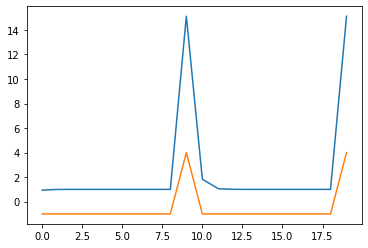

In [ ]:
# lists to store all values of x, m, and v
x_vals_adam = []
m_vals_adam = []
v_vals_adam = []
gamma_vals_adam = []
t_vals = []
grad_vals_adam = list()


# set our starting value of x to be 1, which they prove can be done w.l.o.g
x = 0
m = 0
v = 0
gamma = 0

# set function parameters
C = 4

# set ADAM parameters
alpha = .001
epsilon = 10e-8
beta_1 = 0
beta_2 = 1 / (1 + C ** 2)

#initializing total regret
regret = 0
regrets_adam = []

# define our feasible set as all points between -1 and 1
F = [-1, 1]
n = 50000
for t in range(1, n):
  gradient = toy_example_gradient_oracle(C, 10, t)

  # finding regret, since form is the sum of all past regrets - optimal regret
  # and out optimal regret is -1, it takes the following form

  x_new, m_new, v_new = ADAM_update(x, F, t, m, v, gradient, epsilon, alpha, beta_1, beta_2, project=True)
  gamma = calc_gamma(v_new, v, alpha, alpha)
  
  x_vals_adam.append(x_new)
  m_vals_adam.append(m_new)
  v_vals_adam.append(v_new)
  gamma_vals_adam.append(gamma)
  grad_vals_adam.append(gradient)
  t_vals.append(t)

  x = x_new
  m = m_new
  v = v_new

  regret += x * gradient + gradient
  regrets_adam.append(regret/(t+1))
  # print("X: ", x)
  # t += 1

print(f"ADAM converged. Final X value: {x}, with regret {regret}")
plt.plot(v_vals_adam[0:20])
plt.plot(grad_vals_adam[0:20])

# Toy data example, non-zero $\beta_{1}$

In [ ]:
def toy_2_gradient_oracle(C, t):
  if t % C == 1:
    return C
  return -1


ADAM converged. Final X value: -0.6541113765383949 with regret 2813.6034385090907


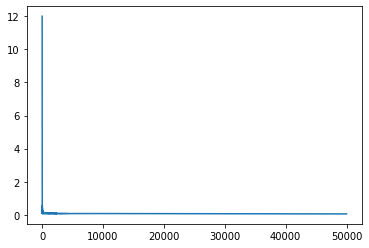

In [ ]:
# lists to store all values of x, m, and v
x_vals = []
m_vals = []
v_vals = []
gamma_vals = []
t_vals = []


# set our starting value of x to be 1, which they prove can be done w.l.o.g
x = 0
m = 0
v = 0
gamma = 0

# set function parameters
# According to this paper, there exists a large enough C that's based on beta_1 and beta_2. For beta_2 = .9, C = 12 is the minimum value based on experimentaiton
# Worth noting that even when C = 11, ADAM will converge to -1, but we will still get a negative gamma at some point
C = 12

# set ADAM parameters
alpha = .001
epsilon = 10e-8


# The paper claims that a non-zero average regret case exists when beta_1 < sqrt(beta_2)
beta_2 = .9

# take the square root and subtract a small amount to make it strictly less than
beta_1 = math.sqrt(beta_2) - .01

#initializing total regret
regret = 0
regrets_adam = []


# define our feasible set as all points between -1 and 1
F = [-1, 1]


for t in range(1, 50000):
  gradient = toy_2_gradient_oracle(C, t)

  # finding regret, since form is the sum of all past regrets - optimal regret
  # and out optimal regret is -1, it takes the following form
  regret += x * gradient + gradient
  regrets_adam.append(regret/t)

  x_new, m_new, v_new = ADAM_update(x, F, t, m, v, gradient, epsilon, alpha, beta_1, beta_2, project=True)
  gamma = calc_gamma(v_new, v, alpha, alpha)
  
  x_vals.append(x_new)
  m_vals.append(m_new)
  v_vals.append(v_new)
  gamma_vals.append(gamma)
  t_vals.append(t)

  x = x_new
  m = m_new
  v = v_new
  
  # print("X: ", x)
  # t += 1

print(f"ADAM converged. Final X value: {x} with regret {regret}")
plt.plot(regrets_adam)

Additional resources:
https://zhongpeixiang.github.io/on-the-convergence-of-adam-and-beyond/
formula for regret. breakdown of some of the math at a higher level

#Toy example graphs - AMSGrad implementation example $\beta_{1} = 0, \beta_{2} = 1/(1+C^{2})$

In [ ]:
# lists to store all values of x, m, and v
x_vals = []
m_vals = []
v_vals = []
gamma_vals_ams = []
t_vals = []


# set our starting value of x to be 1, which they prove can be done w.l.o.g
x = 0
m = 0
v = 0
v_max = 0
gamma = 0

# set function parameters
C = 4

# set ADAM parameters
alpha = .001
epsilon = 10e-8
beta_1 = 0
beta_2 = 1 / (1 + C ** 2)

#initializing total regret
regret = 0
regrets_amsgrad = []

# define our feasible set as all points between -1 and 1
F = [-1, 1]

for t in range(1, 50000):
  gradient = toy_example_gradient_oracle(C, 3, t)

  # finding regret, since form is the sum of all past regrets - optimal regret
  # and out optimal regret is -1, it takes the following form


  x_new, m_new, v_new, v_t = AMS_grad_step(x, F, t, m, v, v_max,  gradient, epsilon, alpha, beta_1, beta_2, project=True)
  gamma = calc_gamma(v_t, v_max, alpha, alpha)


  x_vals.append(x_new)
  m_vals.append(m_new)
  v_vals.append(v_new)
  gamma_vals_ams.append(gamma)
  t_vals.append(t)

  x = x_new
  m = m_new
  v = v_new
  v_max = v_t

  regret += x * gradient + gradient
  regrets_amsgrad.append(regret/t)
  # print("X: ", x)
  # t += 1



AMSGrad converged. Final X value: 1, with regret -0.49395068862926794


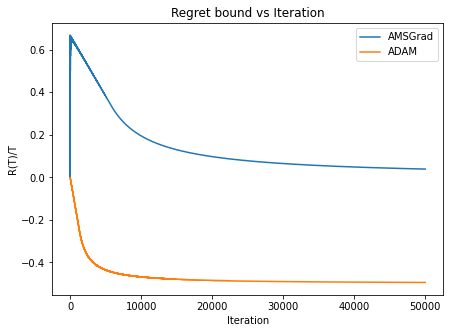

In [ ]:
print(f"AMSGrad converged. Final X value: {x}, with regret {regret/t}")
plt.figure(figsize=(7,5))
plt.title("Regret bound vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("R(T)/T")
plt.plot(regrets_amsgrad[2:])
plt.plot(regrets_adam[2:])
plt.legend(['AMSGrad','ADAM'])

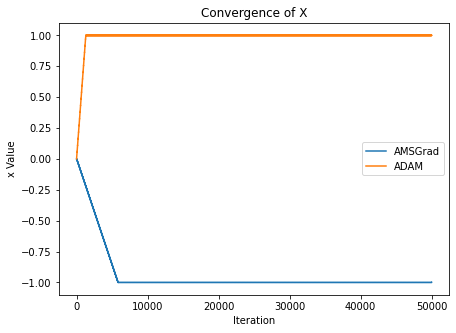

In [ ]:
plt.figure(figsize=(7,5))
plt.title("Convergence of X")
plt.xlabel("Iteration")
plt.ylabel("x Value")
plt.plot(x_vals)
plt.plot(x_vals_adam)
plt.legend(['AMSGrad','ADAM'])

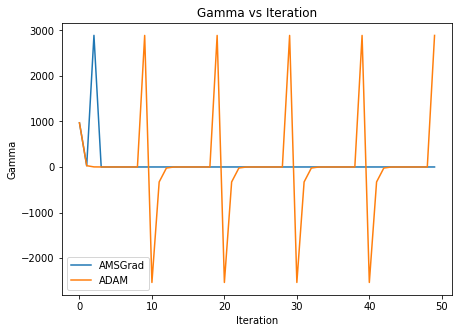

In [ ]:
plt.figure(figsize=(7,5))
plt.title("Gamma vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Gamma")
plt.plot(gamma_vals_ams[0:50])
plt.plot(gamma_vals_adam[0:50])
plt.legend(['AMSGrad','ADAM'])

# Experiments with single feature linear regression, MSE loss (prototype, unused - finished later)


In [ ]:
from sklearn.metrics import mean_squared_error

def MSE_gradient(X, y_true, var1):
  error = y_true - (var1 * X)
  grad = -2 * X.T.dot(error).sum() / len(X)
  return grad

In [ ]:
# generates toy linear regression data with y = coef * x + intercept
def generate_linear_regression_data(n=100, d=1, coef=[5], intercept=1, sigma=0):
  x = np.random.randn(n,d)
  y = (np.dot(x, coef) + intercept).squeeze() + sigma * np.random.randn(n)
  return x, y

# generates linear regression data split between two lines. One with slope coef, one with slope -C.
# Every Cth point in the dataset will be from the outlier distribution
# This is a naive attempt to recreate the conditions of the authors toy data example
def generate_split_linear_regression_data(n, d, coef, intercept, sigma, C):
  outlier_percent = 1 / C
  num_outliers = int(n * outlier_percent)
  num_normal = n - num_outliers

  X_normal, y_normal = generate_linear_regression_data(num_normal, 1, coef, intercept=0)
  X_outlier, y_outlier = generate_linear_regression_data(num_outliers, 1, -C, intercept=0)
  combined_X = np.concatenate((X_normal, X_outlier))
  combined_y = np.concatenate((y_normal, y_outlier))
  assert len(combined_X) == n

  return combined_X, combined_y

In [ ]:
# Generate some simple linear regression data
X, y = generate_linear_regression_data(n=500, d=1, coef=2, intercept=0)
X = X.squeeze()

In [ ]:
X, y = generate_split_linear_regression_data(n=500, d=1, coef=1, intercept=0, sigma=0, C=4)
X = X.squeeze()

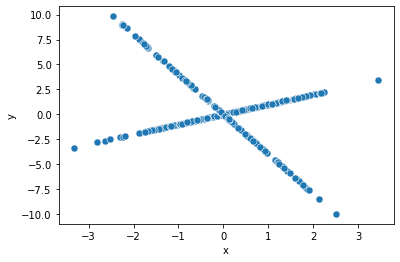

In [ ]:
sns.scatterplot(x=X, y=y, s=50)
plt.xlabel('x');
plt.ylabel('y');

In [ ]:
from numpy.lib.function_base import gradient
# lists to store all values of var1, m, and v
var1_vals = []
m_vals = []
v_vals = []
gamma_vals = []


# set our starting value of var1 to be 0o.g
var1 = 0
m = 0
v = 0
gamma = 0



# set ADAM parameters
alpha = .001
epsilon = 10e-8


# The paper claims that a non-zero average regret case exists when beta_1 < sqrt(beta_2)
beta_2 = .9

# take the square root and subtract a small amount to make it strictly less than
beta_1 = .999

#calculating regret
regret = 0
regrets = []

#optimal = np.linalg.lstsq(X.reshape(X.shape[0],1), y.reshape(y.shape[0],1))[0][0][0]


# define our feasible set as all points between -1 and 1
# we won't project in this example, as our slope can be any real
F = [-1, 1]

for t in range(1, 90000):
  gradient = MSE_gradient(X, y, var1)

  regret += var1 * gradient - optimal * gradient
  regrets.append(regret/t)

  var1_new, m_new, v_new = ADAM_update(var1, F, m, t, v, gradient, epsilon, alpha, beta_1, beta_2, project=False)
  gamma = calc_gamma(v_new, v, alpha, alpha)
  
  var1_vals.append(var1_new)
  m_vals.append(m_new)
  v_vals.append(v_new)
  gamma_vals.append(gamma)

  var1 = var1_new
  m = m_new
  v = v_new
  
  # print("X: ", x)
  # t += 1

print(f"training finished. Final var1 value: {var1}")
#plt.plot(np.array(regrets) / np.array([x for x in range(1, 90000)]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


training finished. Final var1 value: nan


Here the regret will reach a point where it will go up linearly, this is when the weight (var1) will start oscilating around the optimal point.

In [ ]:
x_line = [np.min(X), np.max(X)]
y_line = [val * var1 for val in x_line]
y_pred = np.dot(X, var1)

sns.lineplot(x=x_line, y=y_line, color='red');
sns.scatterplot(x=X, y=y_pred, s=50, color='purple');
plt.xlabel('x');
plt.ylabel('y');

# Experiment with non-iid data sources #

Idea is that if we draw data from a many different distributions, the loss function will become inconsistent and affect the learning rate of adam optimizer.

To generate non-iid datapoints - first generate a sample from a distribution set, then draw an example from that sample distribution.

loss function could be something like MSE - gradient is pretty simple to calculate from that

no idea how this will affect amsgrad

#Experimenting with noisy data - first scenario

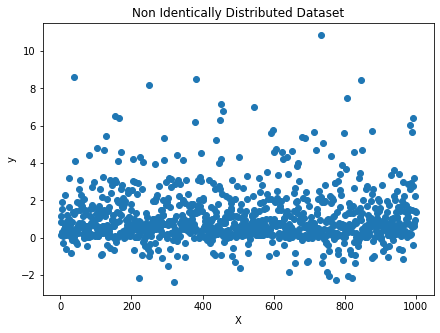

In [ ]:
def gen_data_from_dist(n):

  m = 10;
  m2 = 5
  x = list()
  n_each = n//5
  x.append(norm.rvs(scale=1, size = n_each))
  x.append(gamma.rvs(a = 1.99,size = n_each))
  x.append(expon.rvs(scale=1, size = n_each))
  x.append(uniform.rvs(size=n_each))
  x.append(chi2.rvs(df=2, size=n_each))

  out = np.array(x).flatten()
  np.random.shuffle(out)
  
  x_space = np.linspace(1,len(out),len(out))
  return x_space, out

n_size = 1000;
x_space, non_identical = gen_data_from_dist(n = n_size)

plt.figure(figsize=(7,5))
plt.title("Non Identically Distributed Dataset")
plt.xlabel("X")
plt.ylabel("y")
plt.scatter(x_space,non_identical)

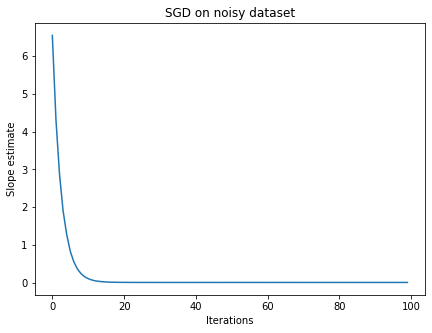

In [ ]:
def SGD(X, y , lr = 1e-8, num_epoch=100, batch_size=1):
  var1 = 10
  var1_vals = list()
  gradients = list()
  for epoch in range(num_epoch):
    #each epoch has batch size 1 for sgd
    for i in range(0, len(X), batch_size):
      x_batch = np.array([random.choices(X, k=batch_size)], dtype=np.uint8)
      y_batch = np.array(y[x_batch])
      grad = MSE_gradient(x_batch, y_batch, var1)
      diff = -lr * grad
      var1 += diff
    var1_vals.append(var1)
    gradients.append(grad)
  return var1_vals, gradients

var, gradients = SGD(x_space, np.array(non_identical))
plt.figure(figsize = (7,5))
plt.title("SGD on noisy dataset")
plt.ylabel("Slope estimate")
plt.xlabel("Iterations")
plt.plot(var)


In [ ]:
def calculate_with_batch(opt,non_identical):
  # lists to store all values of var1, m, and v
  var1_vals = []
  x_vals = []
  m_vals = []
  v_vals = []
  gamma_vals = []
  mse_vals = []
  gradients = list()

  # set our starting value of var1 to be 0o.g
  var1 = 10
  m = 0.1
  v = 0.1
  v_max = 0.1
  gamma = 0
  # set ADAM parameters
  alpha = 0.01
  epsilon = 10e-8
  # The paper claims that a non-zero average regret case exists when beta_1 < sqrt(beta_2)
  beta_2 = 0.9
  # take the square root and subtract a small amount to make it strictly less than
  beta_1 = .99
  # define our feasible set as all points between -1 and 1
  # we won't project in this example, as our slope can be any real
  F = [-1, 1]
  batch_size = 10

  y = np.array(non_identical)

  #epochs
  for t in range(1,100):
    #batch size 1
    for i in range(0, len(non_identical), batch_size):
      x_batch = np.array([random.choices(x_space, k=batch_size)], dtype=np.uint8)
      y_batch = np.array(y[x_batch-1])
      gradient = MSE_gradient(x_batch, y_batch, var1)
      if opt == "adam":
        var1_new, m_new, v_new = ADAM_update(var1, F, t, m, v, gradient, epsilon, alpha, beta_1, beta_2, project=False)
        gamma = calc_gamma(v_new, v, alpha, alpha)
      elif opt == "ams":
        var1_new, m_new, v_new, v_t = AMS_grad_step(var1, F, t, m, v, v_max, gradient, epsilon, alpha, beta_1, beta_2, project=False)
        gamma = calc_gamma(v_t, v_max, alpha, alpha)
        v_max = v_t
      var1 = var1_new
      m = m_new
      v = v_new
      #v_max = v_t
      gamma_vals.append(gamma)
    gradients.append(gradient)
    var1_vals.append(var1_new)
    m_vals.append(m_new)
    v_vals.append(v_new)
      
    #mse_vals.append(mean_squared_error(y, (var1_new *x_batch)))
  return var1_vals,  gradients, gamma_vals

x_adam_noisy, gradients_adam, gamma_vals_adam= calculate_with_batch("adam", non_identical)
x_ams_noisy, gradients_ams, gamma_vals_ams= calculate_with_batch(opt = "ams", non_identical = non_identical)

When the dataset consists of points from multiple distributions, the convergence becomes less stable and more inaccurate, as well as far slower than the SGD convergence.

Additionally, if the batch size is greater than 1, the adam optimizer completely fails to converge - but that is a parameter choice

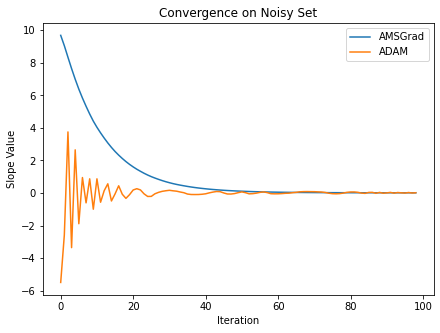

In [ ]:
plt.figure(figsize=(7,5))
plt.title("Convergence on Noisy Set")
plt.xlabel("Iteration")
plt.ylabel("Slope Value")
plt.plot(x_ams_noisy)
plt.plot(x_adam_noisy)
plt.legend(['AMSGrad','ADAM'])

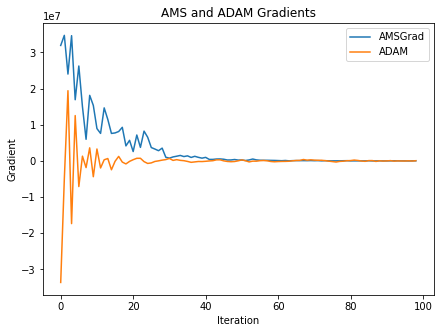

In [ ]:
plt.figure(figsize=(7,5))
plt.title("AMS and ADAM Gradients")
plt.xlabel("Iteration")
plt.ylabel("Gradient")
plt.plot(gradients_ams)
plt.plot(gradients_adam)
plt.legend(['AMSGrad','ADAM'])

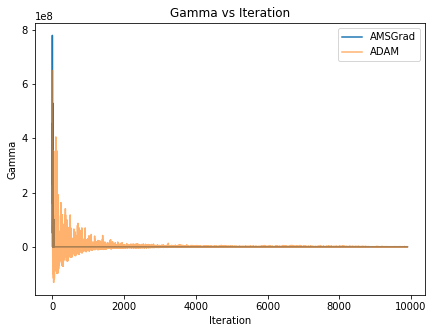

In [ ]:
plt.figure(figsize=(7,5))
plt.title("Gamma vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Gamma")
plt.plot(gamma_vals_ams)
plt.plot(gamma_vals_adam, alpha = 0.6)
plt.legend(['AMSGrad','ADAM'])

#Sampling from different distributions - second scenario

0.6391594432553954
mean: 291.782 and standard deviation: 1591.6265449143525 with outlier cutoff being: -4483.097634743058


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


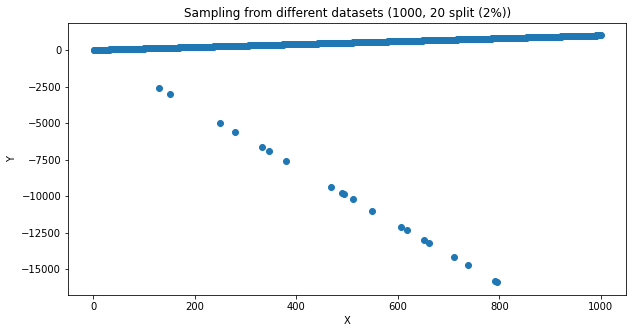

In [ ]:
#generate test data
n = 1000
#m = 2
#b = -1e4
m = 20
b = 0
x_test = np.array(np.linspace(1,n,n))
y_test = np.array(np.linspace(1,n,n))
selection = np.array(random.sample(range(0, n), 20))
y_test[selection] = -m*selection + b
#print(selection)

mean = np.mean(y_test)

std = np.std(y_test)

cutoff = np.mean(y_test) - 3 * np.std(y_test)


plt.figure(figsize=(10,5))
plt.title("Sampling from different datasets (1000, 20 split (2%))")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(x_test,y_test)
#plt.scatter([i for i in range(1000)], [cutoff ] * 1000 )

X = x_test
y = y_test

optimal = np.linalg.lstsq(X.reshape(X.shape[0],1), y.reshape(y.shape[0],1))[0][0][0]

print(optimal)

print(f"mean: {mean} and standard deviation: {std} with outlier cutoff being: {cutoff}")

In [ ]:

def calculate(f, y_test):
  grad_vals_test = list()
  x_vals_test = list()
  m_vals_test = list()
  v_vals_test = list()
  gamma_vals_test = list()
  regrets_test = list()

  x = 0
  m = 0.1
  v = 0.1
  v_max = 0
  gamma = 0


  alpha = .001
  epsilon = 10e-8
  beta_1 = 0.9
  beta_2 = 0.99


  #initizilizing total regret
  regret = 0
  regrets = []

  X = x_test
  y = y_test

  optimal = np.linalg.lstsq(X.reshape(X.shape[0],1), y.reshape(y.shape[0],1))[0][0][0]

  print(optimal)


  F = [-1,1]
  batch_size = 1
  for t in range(1, 500):

    for i in range(0, len(y_test), batch_size):
      x_batch = np.array([random.randint(1,len(y_test)-1)])
      y_batch = np.array(y_test[x_batch])

      gradient = MSE_gradient(x_batch, y_batch, x) #toy_example_gradient_oracle(C, 10, t)
      
      if f == "adam":
        x_new, m_new, v_new = ADAM_update(x, F, t, m, v, gradient, epsilon, alpha, beta_1, beta_2, project=False)
      elif f == "ams":
        x_new, m_new, v_new, v_t = AMS_grad_step(x, F, t, m, v, v_max, gradient, epsilon, alpha, beta_1, beta_2, project=False)
      gamma = calc_gamma(v_new, v, alpha, alpha)
      
      x = x_new
      m = m_new
      v = v_new

      if f == "ams":
        v_max = v_t

    # finds the difference between optimal mean_squared_error and current mean_squared_error
    regret += mean_squared_error(y, X*x) - mean_squared_error(y, X*optimal)
    regrets_test.append(regret/t)    
    
    x_vals_test.append(x_new)
    m_vals_test.append(m_new)
    if f == "ams":
      v_vals_test.append(v_max)
    elif f == "adam":
      v_vals_test.append(v_new)
    gamma_vals_test.append(gamma)
    grad_vals_test.append(gradient)



  print(f"Converged. Final X value: {x}, with regret {regret/t}")
  return x_vals_test, m_vals_test, v_vals_test, grad_vals_test, regrets_test

x_adam, _, v_adam , grad_adam , regret_adam = calculate("adam", y_test)
x_ams, _, v_ams, grad_ams , regret_ams = calculate("ams", y_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


0.6391594432553954
Converged. Final X value: 0.7352610428678537, with regret 4982.622072494163
0.6391594432553954


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Converged. Final X value: 0.6441816633417623, with regret 747.1482050444414


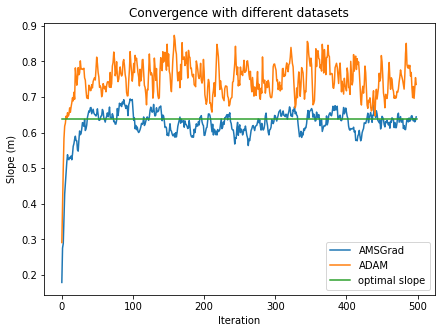

In [ ]:
plt.figure(figsize=(7,5))
plt.title("Convergence with different datasets")
plt.xlabel("Iteration")
plt.ylabel("Slope (m)")
plt.plot(x_ams)
plt.plot(x_adam)
plt.plot([optimal] * 500)
plt.legend(['AMSGrad','ADAM','optimal slope'])

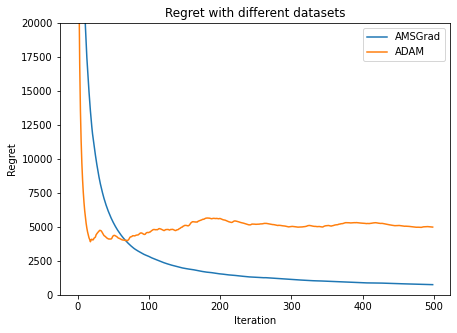

In [ ]:
plt.figure(figsize=(7,5))
plt.title("Regret with different datasets")
plt.xlabel("Iteration")
plt.ylabel("Regret")
plt.ylim(0, 20000)
plt.plot(regret_ams)
plt.plot(regret_adam)
plt.legend(['AMSGrad','ADAM'])

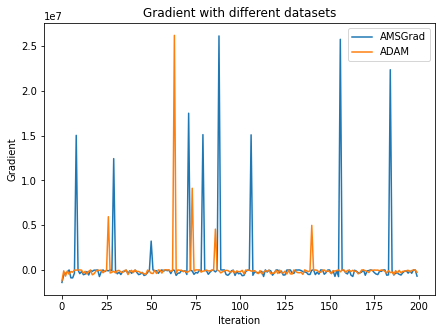

In [ ]:
plt.figure(figsize=(7,5))
plt.title("Gradient with different datasets")
plt.xlabel("Iteration")
plt.ylabel("Gradient")
plt.plot(grad_ams[0:200])
plt.plot(grad_adam[0:200])
plt.legend(['AMSGrad','ADAM'])

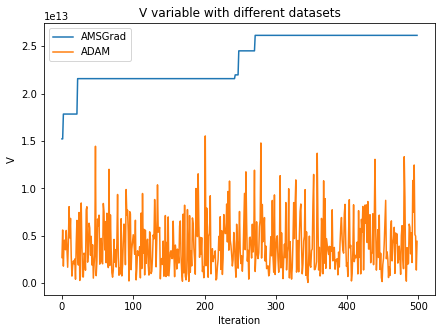

In [ ]:
plt.figure(figsize=(7,5))
plt.title("V variable with different datasets")
plt.xlabel("Iteration")
plt.ylabel("V")
plt.plot(v_ams)
plt.plot(v_adam)
plt.legend(['AMSGrad','ADAM'])